In [17]:
import numpy as np
import pandas as pd
from numpy import *
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import tree
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [18]:
train_df=pd.read_csv('train_90_df.csv',index_col=0)
test_df=pd.read_csv('test_90_df.csv',index_col=0)

In [19]:
train_df.shape,test_df.shape

((3623, 12), (1877, 12))

In [20]:
train_df.head()

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30004144.0,-3.840278,8.0,0.7,114.0,135.0,103.0,13.0,5.1,0.0,26.659722,25.000000
1,30004144.0,-0.240278,6.8,0.7,133.0,135.0,102.0,11.8,4.8,0.0,26.659722,25.000000
2,30006983.0,-14.611667,8.0,0.8,156.0,132.0,102.0,10.1,8.2,0.0,14.055000,49.000000
3,30006983.0,0.521667,7.1,1.0,89.0,136.0,108.0,9.9,9.5,0.0,14.055000,49.000000
4,30023204.0,0.518056,8.2,1.6,124.0,130.0,100.0,8.3,27.0,0.0,47.268056,24.166667


In [21]:
test_df.head()

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,icu_intime,vent_start,vent_duration
0,30005366.0,8.550278,8.8,6.7,41.0,139.0,100.0,9.20,9.4,0.0,20.383611,6.00
1,30034749.0,-131.777778,9.9,0.8,166.0,140.0,100.0,9.65,9.3,0.0,26.522222,20.45
2,30034749.0,-122.194444,8.4,0.8,125.0,143.0,100.0,14.90,5.8,0.0,26.522222,20.45
3,30034749.0,-98.694444,10.0,0.8,141.0,139.0,97.0,9.65,9.3,0.0,26.522222,20.45
4,30034749.0,-88.444444,10.3,0.7,157.0,138.0,98.0,9.65,9.3,0.0,26.522222,20.45


## Scaling: MinMax Scaler

X_train=train_df.drop(columns=['stay_id','charttime','icu_intime','vent_start','vent_duration'])
X_test=test_df.drop(columns=['stay_id','charttime','icu_intime','vent_start','vent_duration'])
y_train=train_df['vent_duration']
y_test=test_df['vent_duration']

In [22]:
X_train=train_df.drop(columns=['stay_id','icu_intime','vent_start','vent_duration'])
X_test=test_df.drop(columns=['stay_id','icu_intime','vent_start','vent_duration'])
y_train=train_df['vent_duration']
y_test=test_df['vent_duration']

In [23]:
X_train.columns

Index(['charttime', 'calcium', 'creatinine', 'glucose', 'sodium', 'chloride',
       'hemoglobin', 'wbc'],
      dtype='object')

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X_train_scaled.shape,X_test_scaled.shape,y_train.shape,y_test.shape

((3623, 8), (1877, 8), (3623,), (1877,))

In [26]:
y_train.values.ravel()

array([25.        , 25.        , 49.        , ..., 31.26666667,
       31.26666667, 31.26666667])

# Modelling

## 1. Decision Tree 

In [27]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))

## 1.1 Decisin Tree with Grid Search

In [28]:
#set base model
dtr= DecisionTreeRegressor()

#set params
max_depth = [3,4,5,6,7]
max_features=["auto","log2","sqrt",None]

#put into gridsearch
param_grid = { 
    'min_samples_leaf':[5,10,50,100],
    'max_features':["auto","log2","sqrt",None],
    'max_depth' : [3,4,5,6,7,None],
    'random_state' : [42]
}

#set cross validation
tss = TimeSeriesSplit(n_splits=5)

dt_grid = GridSearchCV(dtr, param_grid=param_grid, cv=tss, n_jobs=-1)

In [29]:

from datetime import datetime

start_time=timer(None)

dt_grid.fit(X_train_scaled, y_train.values.ravel())

timer(start_time)

print(dt_grid.best_score_)
print(dt_grid.best_params_)


0.0 : 0.0 : 8.67
-0.09111341525736641
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'random_state': 42}


In [30]:
%%capture
print(dt_grid.cv_results_)

In [31]:
#retrain it with best params
best_dtr = DecisionTreeRegressor(max_depth=3,max_features='sqrt',min_samples_leaf=100,random_state = 42)
best_dtr.fit(X_train_scaled, y_train.values.ravel())
best_dtr_y_pred=best_dtr.predict(X_test_scaled)

In [32]:
def evaluation(y_test,best_dtr_y_pred):
    print('Mean Squared Error:', mean_squared_error(y_test, best_dtr_y_pred))
    print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, best_dtr_y_pred)))
    print('Mean Absolute Error:', mean_absolute_error(y_test, best_dtr_y_pred))
    print('R2',r2_score(y_test, best_dtr_y_pred))
    
def plotting(y_test,best_dtr_y_pred,modelname='Best Model'):
    best_dtr_mae=mean_absolute_error(y_test, best_dtr_y_pred)
    print('MAE: %.3f' % best_dtr_mae)
    # plot expected vs predicted
    fig,ax=plt.subplots(figsize=(15,8))
    plt.plot(y_test.values.ravel(), label='Real Label')
    plt.plot(best_dtr_y_pred, label= modelname)
    plt.legend()
    plt.show()
    
# compare the predicted and ground truth
import matplotlib.pyplot as plt
def visualize(test_y, pred_y):
    plt.figure(figsize=(5, 5))
    plt.scatter(test_y, pred_y)
    x = np.linspace(*plt.xlim())
    plt.plot(x, x, color='red', label="y=x")

Mean Squared Error: 638.4770527790331
Mean Root Squared Error: 25.2681034662088
Mean Absolute Error: 19.005835468309986
R2 0.04327840545290007
MAE: 19.006


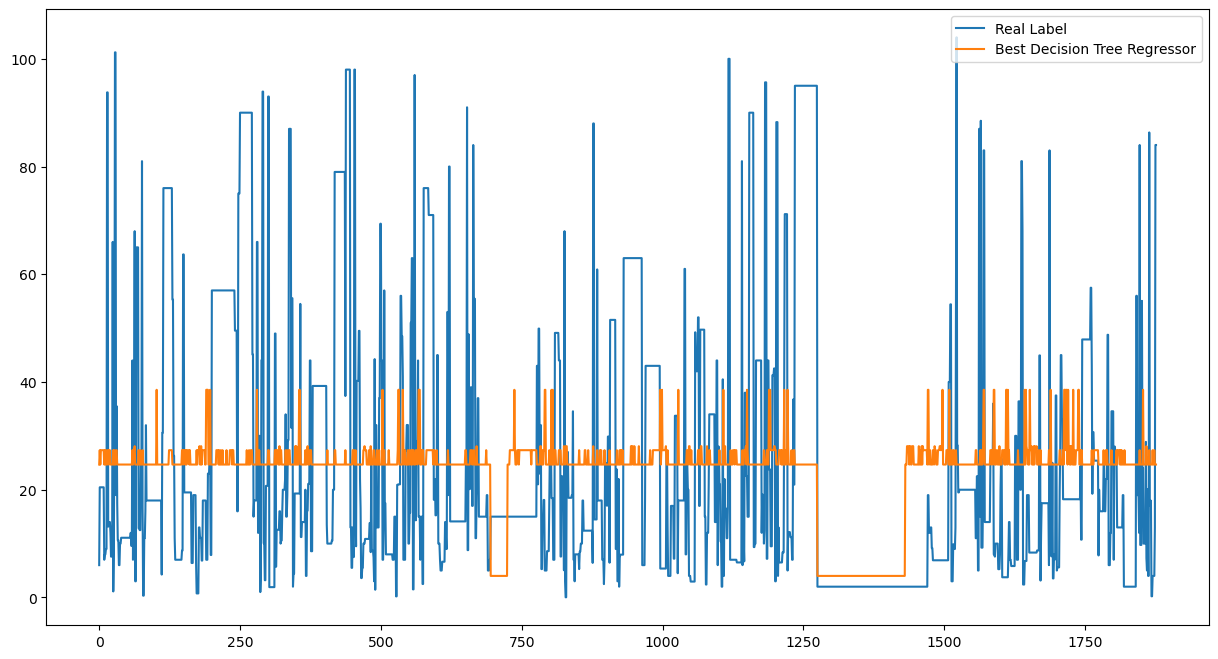

In [36]:
evaluation(y_test,best_dtr_y_pred)
plotting(y_test,best_dtr_y_pred,modelname='Best Decision Tree Regressor')

In [37]:
import graphviz
from sklearn import tree

In [38]:
best_dtr

DecisionTreeRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=100,
                      random_state=42)

Text(0.5, 1.0, 'Decision Tree Regressor')

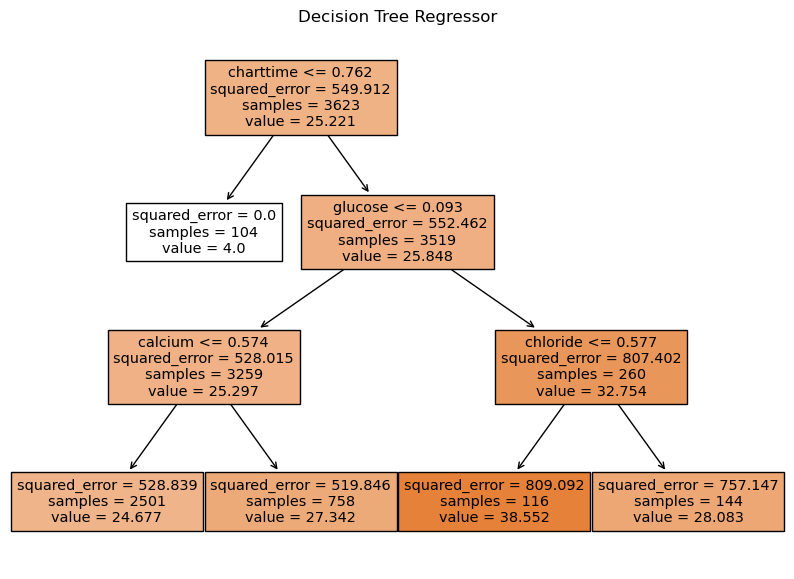

In [39]:
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(best_dtr, feature_names=X_train.columns, filled=True)
plt.title('Decision Tree Regressor')

## 1.2 Decision Tree Prediction Intervals 

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor

RMSE = 25.2681034662088


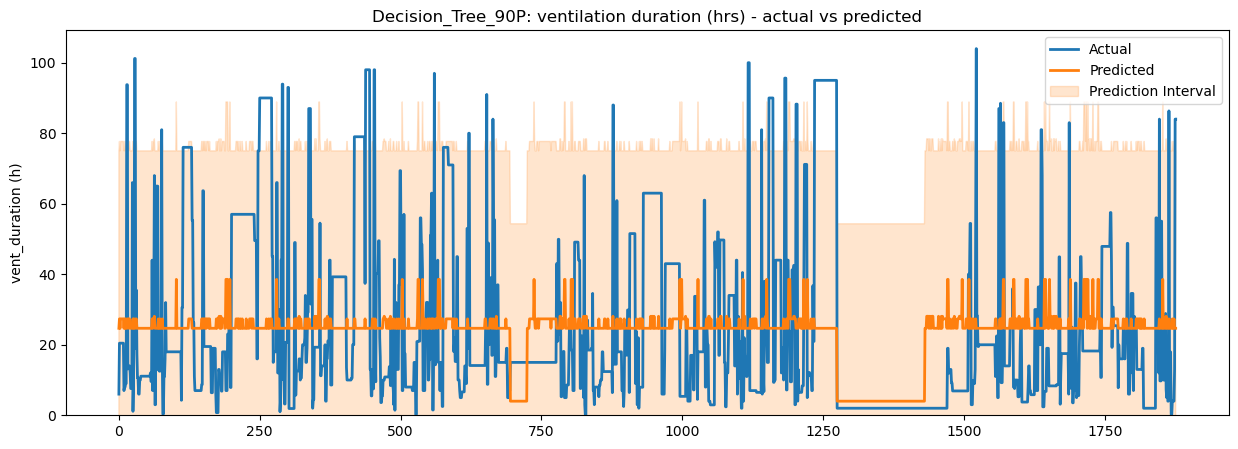

## Feature importance ##

charttime : 0.6625347555942331
calcium : 0.05676818319371597
creatinine : 0.0
glucose : 0.1839579445502297
sodium : 0.0
chloride : 0.09673911666182115
hemoglobin : 0.0
wbc : 0.0

## Shapley Additive Explanations - ShAP value ##



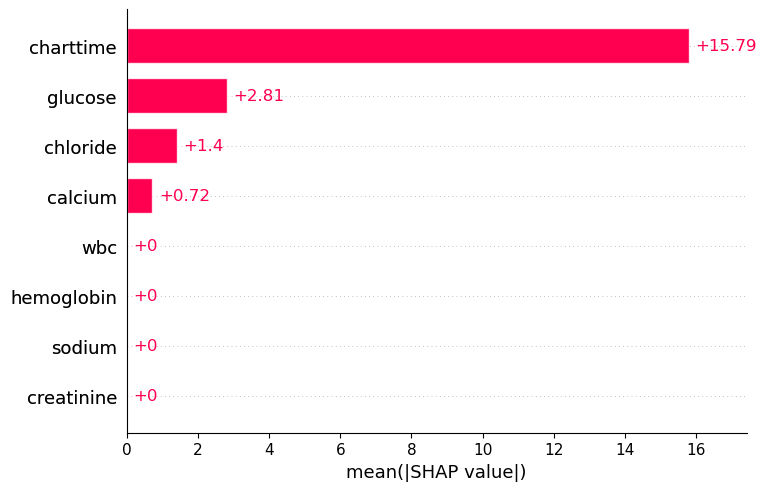

In [40]:
train_90_df = pd.read_csv('train_90_df.csv')
train_90_df = train_90_df.drop(train_90_df.columns[0], axis=1)

test_90_df = pd.read_csv('test_90_df.csv')
test_90_df = test_90_df.drop(test_90_df.columns[0], axis=1)

y_test = test_90_df['vent_duration']
X_test = test_90_df.loc[:, ~train_90_df.columns.isin(['stay_id','icu_intime', 'vent_start', 'vent_duration'])]

y_train = train_90_df['vent_duration']
X_train = train_90_df.loc[:, ~train_90_df.columns.isin(['stay_id','icu_intime', 'vent_start','vent_duration'])]


from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn import set_config

#set_config(transform_output="pandas")



## Predict median
median_pipeline = Pipeline([('scaler', MinMaxScaler()), ('dtr',DecisionTreeRegressor(max_depth=3,max_features='sqrt',min_samples_leaf=100,random_state = 42))])
median_pipeline.fit(X_train, y_train)

pred_median=median_pipeline.predict(X_test)
# Evaluate model performance at record level


print('RMSE = ' + str(mean_squared_error(y_test, pred_median, squared=False)))

# Plot estimated prediction intervals on test set

mapie = MapieRegressor(
    median_pipeline, method="naive", cv=TimeSeriesSplit(), agg_function=None, n_jobs=-1
)

mapie.fit(X_train, y_train)
pred_median, y_pis = mapie.predict(X_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test, lw=2, label="Actual", c="C0")
ax.plot(y_test.index, pred_median, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    y_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Interval",
)
plt.title("Decision_Tree_90P: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()

print("## Feature importance ##")
print()

for i in range(len(median_pipeline[1].feature_importances_)):
    print(X_train.columns[i], ":" , median_pipeline[1].feature_importances_[i])

#dtr_importances=best_dtr.feature_importances_
#print(len(dtr_importances))
#dtr_importances = pd.Series(dtr_importances, index=X_train.columns[1:])
#dtr_importances
    
print()
import shap
print("## Shapley Additive Explanations - ShAP value ##")
print()
explainer = shap.Explainer(median_pipeline[1])
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=12) # default is max_display=12




# 

# 

# 

## 2. Random Forest

In [41]:
rfr = RandomForestRegressor(n_estimators=1000,bootstrap=False,n_jobs=-1)
rfr.fit(X_train_scaled, y_train)
rfr_y_pred=rfr.predict(X_test_scaled)

In [42]:
rfr

RandomForestRegressor(bootstrap=False, n_estimators=1000, n_jobs=-1)

Mean Squared Error: 1089.3007991196882
Mean Root Squared Error: 33.00455724774517
Mean Absolute Error: 23.498460539843755
R2 -0.6322553691461996
MAE: 23.498


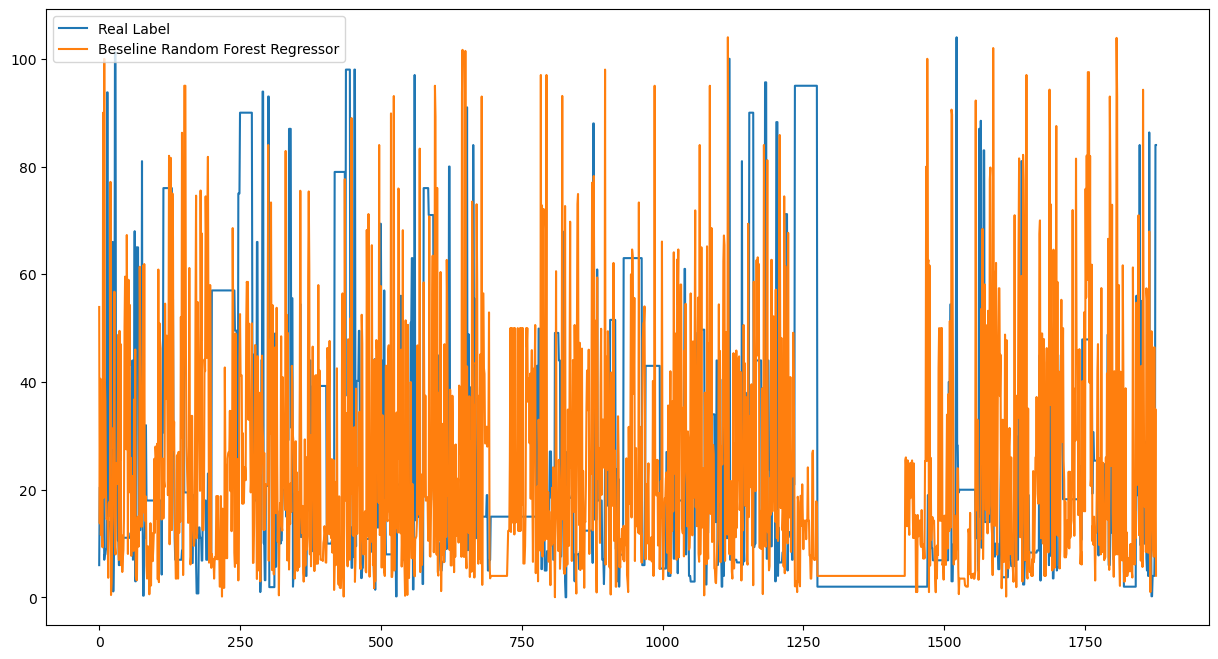

In [43]:
evaluation(y_test,rfr_y_pred)
plotting(y_test,rfr_y_pred,modelname='Beseline Random Forest Regressor')

In [44]:
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances

charttime     0.189143
calcium       0.095495
creatinine    0.141600
glucose       0.113562
sodium        0.124173
chloride      0.126516
hemoglobin    0.097554
wbc           0.111957
dtype: float64

## 1.1 Random Forest + GridSearchCV 

In [47]:
rfr = RandomForestRegressor(n_estimators=1000,bootstrap=False,n_jobs=-1)


rfr_grid = { 
    'criterion':['squared_error'],
    'n_estimators': [300,400,500,800,1000],
    'max_features': ["log2","sqrt",None],
    'max_depth' : [3,4,5,6,7,None],
    'random_state' : [42]
}

#set cross validation
tss = TimeSeriesSplit(n_splits=5)                    

rfr_grid = GridSearchCV(estimator=rfr, param_grid=rfr_grid, cv=tss)


In [48]:
start_time=timer(None)

rfr_grid.fit(X_train_scaled, y_train.values.ravel())

timer(start_time)

print(rfr_grid.best_score_)
print(rfr_grid.best_params_)

0.0 : 9.0 : 20.34
-0.05134499945325224
{'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000, 'random_state': 42}


In [49]:
rfr_grid.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=3, max_features='sqrt',
                      n_estimators=1000, n_jobs=-1, random_state=42)

In [50]:
best_rfr = RandomForestRegressor(criterion= 'squared_error',n_estimators = 1000, max_features = 'sqrt', max_depth = 3, random_state = 42)
best_rfr.fit(X_train_scaled, y_train.ravel())
# Predict on test data
best_rfr_y_pred  = best_rfr.predict(X_test_scaled)

Mean Squared Error: 641.5878306903505
Mean Root Squared Error: 25.329584100224594
Mean Absolute Error: 19.31417779887
R2 0.03861708146225151
MAE: 19.314


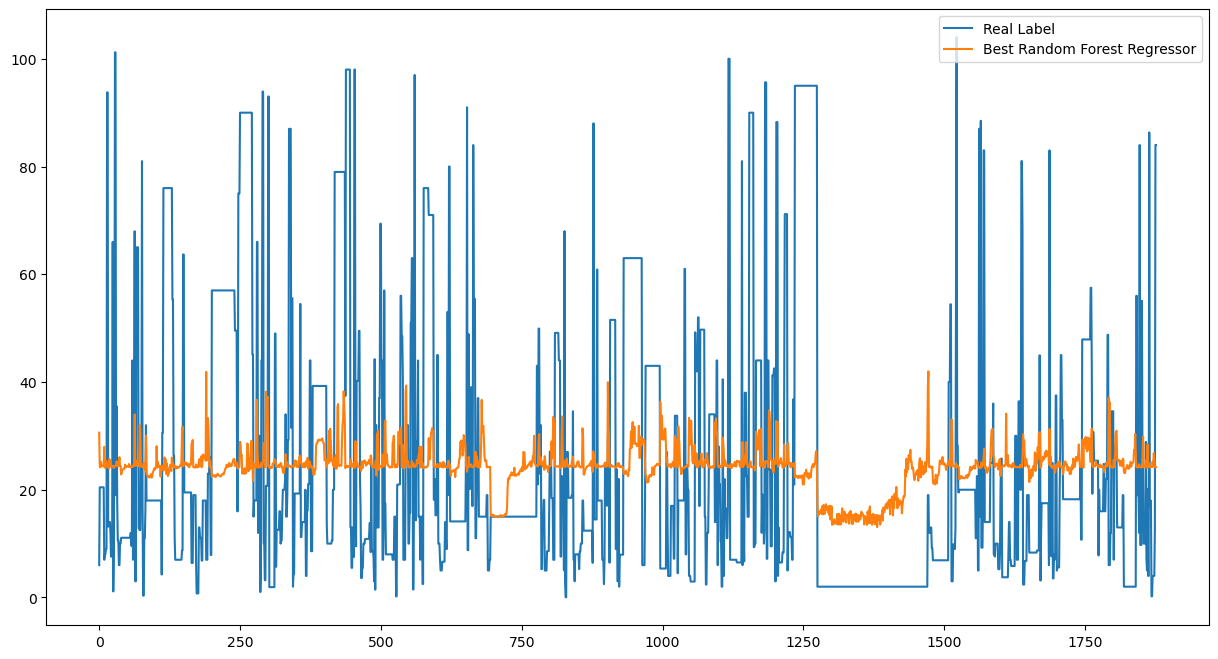

In [51]:
evaluation(y_test,best_rfr_y_pred)
plotting(y_test,best_rfr_y_pred,modelname='Best Random Forest Regressor')

In [52]:
%%capture
print(rfr_grid.cv_results_)

In [53]:
importances = best_rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances

charttime     0.218990
calcium       0.053252
creatinine    0.220290
glucose       0.099815
sodium        0.103274
chloride      0.153858
hemoglobin    0.040989
wbc           0.109532
dtype: float64

## 2.2 Random Forest Prediction Intervals


RMSE = 25.267061077690236


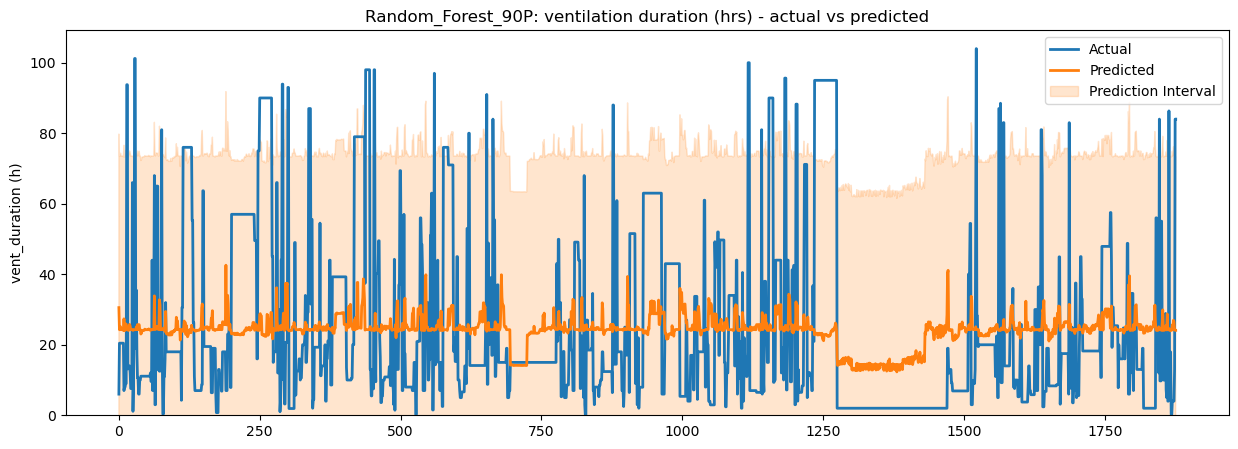

## Feature importance ##

charttime : 0.2401916339698701
calcium : 0.048100454804692924
creatinine : 0.23037378302551015
glucose : 0.08359041054346691
sodium : 0.10431536533448114
chloride : 0.15561715718395708
hemoglobin : 0.031165000379471137
wbc : 0.10664619475855065

## Shapley Additive Explanations - ShAP value ##



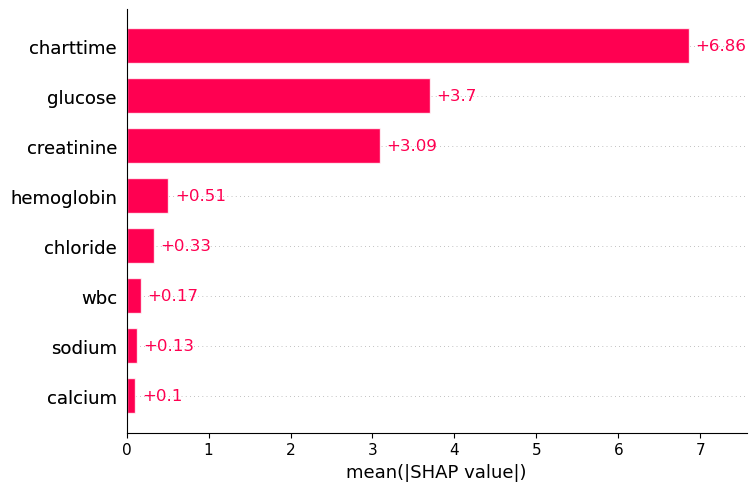

In [58]:
train_90_df = pd.read_csv('train_90_df.csv')
train_90_df = train_90_df.drop(train_90_df.columns[0], axis=1)

test_90_df = pd.read_csv('test_90_df.csv')
test_90_df = test_90_df.drop(test_90_df.columns[0], axis=1)

y_test = test_90_df['vent_duration']
X_test = test_90_df.loc[:, ~train_90_df.columns.isin(['stay_id','icu_intime', 'vent_start', 'vent_duration'])]

y_train = train_90_df['vent_duration']
X_train = train_90_df.loc[:, ~train_90_df.columns.isin(['stay_id','icu_intime', 'vent_start','vent_duration'])]


from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn import set_config

#set_config(transform_output="pandas")



## Predict median
median_pipeline = Pipeline([('scaler', MinMaxScaler()), ('rfr',RandomForestRegressor(criterion='squared_error',ccp_alpha=0.5,n_estimators = 1000, max_features = 'sqrt', max_depth = 3, random_state = 42,bootstrap=False,n_jobs=-1))])
median_pipeline.fit(X_train, y_train)


# Evaluate model performance at record level


print('RMSE = ' + str(mean_squared_error(y_test, pred_median, squared=False)))

# Plot estimated prediction intervals on test set

mapie = MapieRegressor(
    median_pipeline, method="naive", cv=TimeSeriesSplit(), agg_function=None, n_jobs=-1
)

mapie.fit(X_train, y_train)
pred_median, y_pis = mapie.predict(X_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test, lw=2, label="Actual", c="C0")
ax.plot(y_test.index, pred_median, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    y_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Interval",
)
plt.title("Random_Forest_90P: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()

print("## Feature importance ##")
print()

#for i in range(len(median_pipeline[1].feature_names_in_)):
#    print(median_pipeline[1].feature_names_in_[i], ":" , median_pipeline[1].feature_importances_[i])

for i in range(len(median_pipeline[1].feature_importances_)):
    print(X_train.columns[i], ":" , median_pipeline[1].feature_importances_[i])
    
    
print()
import shap
print("## Shapley Additive Explanations - ShAP value ##")
print()
explainer = shap.Explainer(median_pipeline[1])
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=12) # default is max_display=12




In [59]:
# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': pred_median})
y_pis = y_pis.reshape(1877, 2)
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. e.g."randomforest_90_output"
randomforest_90_output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1)
print(randomforest_90_output)
randomforest_90_output.to_csv('randomforest_90_output.csv')


      y_test     y_pred   lower_pi   upper_pi
0       6.00  30.533541 -18.692999  79.760082
1      20.45  24.280486 -24.946054  73.507027
2      20.45  24.273460 -24.953080  73.500000
3      20.45  25.112584 -24.113956  74.339124
4      20.45  24.290980 -24.935560  73.517520
...      ...        ...        ...        ...
1872    4.00  26.943234 -22.283307  76.169774
1873    4.00  26.512199 -22.714341  75.738739
1874   13.00  24.321121 -24.905420  73.547661
1875   84.00  24.078296 -25.148244  73.304836
1876   84.00  24.085680 -25.140860  73.312220

[1877 rows x 4 columns]
